In [ ]:
### with img - amin(img) is it just aligning to the edge?
### why should the rot of imgs matter if rot invariant
### non negative volume
### effect of borders
### should the min rot dist of out of plane -> in plane rot be the in plane?
### compute only distance at angle 0?


### Make non rotational distances
### check transforms
### add enforce non negative

In [1]:
import os
import time
import logging

import mrcfile
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage as ndi
from scipy.spatial.transform import Rotation as R

### my library

import plots
import utils
import images
import distances
import transforms
import alignments
import cryo

### ASPIRE library

from aspire.source.simulation import Simulation
from aspire.utils import Rotation, rots_to_clmatrix
from aspire.volume import Volume

In [2]:
# def normalized_minimum_angular_dists(dists_dict):
#     dists = np.array([np.amin(v) for k, v in dists_dict.items()])
#     return dists / np.amax(dists)

In [3]:
# with mrcfile.new('Data/cylinder_L128_r20_h100.mrc', overwrite=True) as mrc:
#     mrc.set_data(C.astype('float32'))

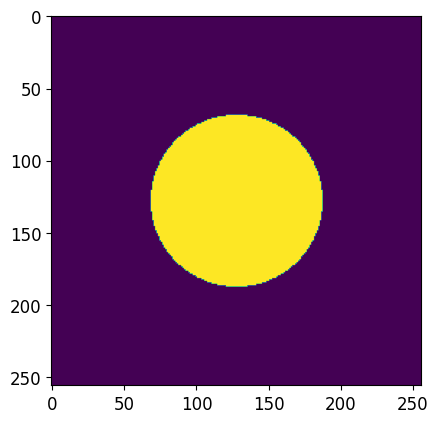

In [12]:
n_imgs = 50 
L = 256
radius = 60
height = 200

# n_imgs = 30 
# L = 128
# radius = 20
# height = 100 

# n_imgs = 30 
# L = 65
# radius = 15
# height = 50

center = L//2

C = np.zeros((L,L,L))
rdists = utils.radial_distance_grid((L,L))

bot = center - height // 2
top = center + height // 2

zs = np.arange(bot, top)

for z in zs:
    mask = rdists < radius
    C[z, :, :] = mask  # top view
    # C[:, z, :] = mask
    # C[:, :, z] = mask  # side view

# C = C * np.random.randint(0, 2, (L,L,L))
# C = C * np.random.randint(0, 2, (L,L,L))
# C = C * np.random.randint(0, 2, (L,L,L))
# C = C * np.random.randint(0, 2, (L,L,L))
# C = C * np.random.randint(0, 2, (L,L,L))
# C = C * np.random.randint(0, 2, (L,L,L))
# C = C * np.random.randint(0, 2, (L,L,L))
# C = C * np.random.randint(0, 2, (L,L,L))
# C = C * np.random.randint(0, 2, (L,L,L))
# C = C * np.random.randint(0, 2, (L,L,L))

# C = C * abs(np.random.normal(0, 1, C.shape))    
# C = C * np.random.randint(1, 100, C.shape)

cyl = Volume(C.astype('float32'))

plt.imshow(np.sum(C, axis=0))
plt.show()

### TRY blur cylinder instead of projection images

In [13]:
### generate rotations

np.random.seed(0)

a_max = 45

r = cryo.get_euler_from_gradient_over_Y(n_imgs+1, angle_max=np.deg2rad(a_max))
# r[0] = [0, 0, 0]  # EV: set first to zero (the reference) depending on how r is generated
# r = np.roll(r, 0) # switch axis
# r[:, ...] = np.pi/4

In [20]:
### Generate images

logger = logging.getLogger(__name__)

rots = Rotation.from_euler(r)  # list of rotations in Aspire format
shifts = np.zeros((n_imgs+1, 2))  # not including shifts
amplitudes = np.ones(n_imgs+1)


src = Simulation(vols=cyl,  # our Volume
                  L=L,  # resolution, should match Volume
                  n=n_imgs+1,  # number of projection images
                  angles=rots.angles,  # pass our rotations as Euler angles
                  offsets=shifts,  # translations (wrt to origin)
                  amplitudes=amplitudes,  # amplification (1 is identity)
                  seed=12345,  # RNG seed for reproducibility
                  dtype=cyl.dtype  # match our datatype to the Volume.
                )

clean_images = src.projections[:].asnumpy().copy()


##### EXTRA #####


# shifts = False
# s = 5
# if shifts:
#     # shifts = np.random.choice((-s, s), (n_imgs+1, 2))  # include shifts
#     shifts = np.array([[s, s] for _ in range(n_imgs+1)])  # if non random shifts
#     shifts[0] = [0, 0]  # set reference shift to zero
#     for idx in range(n_imgs+1):
#         ty, tx = shifts[idx]
#         clean_images[idx] = utils.translate(clean_images[idx], ty, tx)
        
### EV: dist is rot invariant, but add this for visualization?
### skip first image (the reference)
# for idx, img in enumerate(clean_images[1:]):
#     clean_images[idx+1] = utils.rotate(img, 90)

# for idx, img in enumerate(clean_images[:]):
#     clean_images[idx] = utils.rotate(img, 90)

### EV: ENFORCE NON NEGATIVE IMAGES ??? ( seems to matter for nrf )   
# clean_images = clean_images - np.amin(clean_images)
# clean_images = abs(clean_images)
# clean_images = np.where(clean_images < 0, 1e-5, clean_images)  # how to set this?

# rdists = utils.radial_distance_grid(clean_images[0].shape)
# m = utils.sphere_mask(rdists, 45)
# clean_images = clean_images * ~m

# EV: Add slight B factor?
# clean_images = np.where(clean_images < 1e-8, 1e-8, clean_images)
clean_images = np.array([cryo.apply_b_factor(img, 1, 100) for img in clean_images]).real

imgs = images.Image(clean_images, normalize=True, mask=True, radius=False, add_noise=False, snr=10).preprocess_images()

2024-11-01 16:16:36,228 INFO [aspire.source.image] Creating Simulation with 51 images.


/home/ev9102/ASPIRE-Python/src/aspire/utils/rotation.py:85: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  euler_angles = rotations.as_euler(self._seq_order, degrees=False).astype(


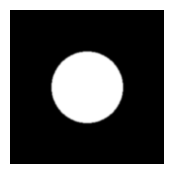

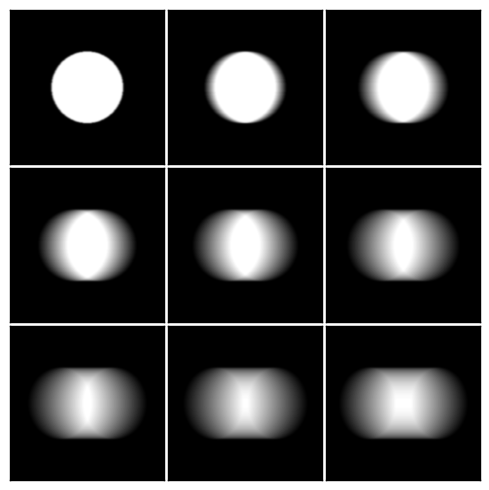

In [21]:
plt.figure(figsize=(2,2))
plt.imshow(imgs[0], cmap='gray')
plt.axis('off')
plt.show()
h=3
plots.square_tile_plot(imgs[1::n_imgs//h**2], h, size=5, spine_colors=['k' for _ in range(h**2)])

In [22]:
N, ny, nx = imgs.shape
n_points = ny
angles = np.linspace(0, 360, ny, endpoint=False)
n_theta = len(angles)

refs = np.array([imgs[0], imgs[0]])
imgs = imgs[:]  # or skip first image

normalize = True

### sliced Wasserstein (no ramp filter)
t = time.time()
U = transforms.Transform(refs, apply_ramp=False, angles=angles, n_points=n_points).inverse_cdf_transform()
V = transforms.Transform(imgs, apply_ramp=False, angles=angles, n_points=n_points).inverse_cdf_transform()
    
dists_sw_nrf = np.array([distances.sliced_distance(U[0], V[idx]) for idx in range(N)])
    
print('SW nrf runtime: ', time.time() - t)


### sliced Wasserstein distance (averaged)
t = time.time()
Up, Un = transforms.Transform(refs, apply_ramp=True, angles=angles, n_points=n_points).signed_inverse_cdf_transform()
Vp, Vn = transforms.Transform(imgs, apply_ramp=True, angles=angles, n_points=n_points).signed_inverse_cdf_transform()

dists_sw_avg = np.array([distances.signed_sliced_distance(Up[0], Vp[idx], Un[0], Vn[idx]) for idx in range(N)])
    
print('SW avg runtime: ', time.time() - t)


### max sliced Wasserstein distance
t = time.time()
U = transforms.Transform(refs, apply_ramp=False, angles=angles, n_points=n_points).inverse_cdf_transform()
V = transforms.Transform(imgs, apply_ramp=False, angles=angles, n_points=n_points).inverse_cdf_transform()
    
dists_sw_max = np.array([distances.max_sliced_distance(U[0], V[idx]) for idx in range(N)])
    
print('SW max runtime: ', time.time() - t)


### *** SLICED CRAMER DISTANCES *** ###
print('\n')


### sliced Cramer (no ramp filter)
t = time.time()
U = transforms.Transform(refs, apply_ramp=False, angles=angles, n_points=n_points).cdf_transform(rescale=True)
V = transforms.Transform(imgs, apply_ramp=False, angles=angles, n_points=n_points).cdf_transform(rescale=True)

dists_sc_nrf = np.array([distances.sliced_distance(U[0], V[idx]) for idx in range(N)])

print('SW nrf runtime: ', time.time() - t)


###### OTHER DISTS ######
print('\n')

## Brute force rotations
t = time.time()
    
dists_bfr = np.array([distances.l2_distance(refs[0], imgs[idx]) for idx in range(N)])
    
print('    BF runtime: ', time.time() - t)


# ### FTK 
# t = time.time()
# corr_ftk, angles_est_ftk, shift_est_ftk = distances.ftk_align(refs[0], imgs, n_psi=L, B=1) 
# angles_est_ftk = 360 - angles_est_ftk  # not sure why I need this
# print('   FTK runtime: ', time.time() - t)


# ### Wavelet EMD 
# t = time.time()
# dists_dict_wemd = {idx: distances.wemd_rotational_distance(refs[0], imgs[idx], np.array([0]), wavelet='sym3', level=3) for idx in range(N)}
# dists_emd = np.array([np.amin(v) for k, v in dists_dict_wemd.items()])
# if normalize:
#     dists_emd = normalized_minimum_angular_dists(dists_dict_wemd)
# print('  WEMD runtime: ', time.time() - t)


# ### Wasserstein 2
# t = time.time()
# M = distances.compute_transport_matrix(imgs[0], metric='sqeuclidean')
# dists_dict_w2 = {idx: np.sqrt(distances.rotational_wasserstein_distance(refs[0], imgs[idx], np.array([0]), M)) for idx in range(N)}
# dists_w2 = np.array([np.amin(v) for k, v in dists_dict_w2.items()])
# if normalize:
#     dists_w2 = normalized_minimum_angular_dists(dists_dict_w2)
# print('    W2 runtime: ', time.time() - t)

SW nrf runtime:  0.9262211322784424
SW avg runtime:  1.0925703048706055
SW max runtime:  0.9125726222991943


SW nrf runtime:  0.7933406829833984


    BF runtime:  0.004389524459838867


In [23]:
t = np.linspace(0, a_max, N)[:]  # REPLACE WITH AXIS ANGLE DIFFERENCE

upper_bound_sw = 0.76*np.deg2rad(t)/np.sqrt(L)

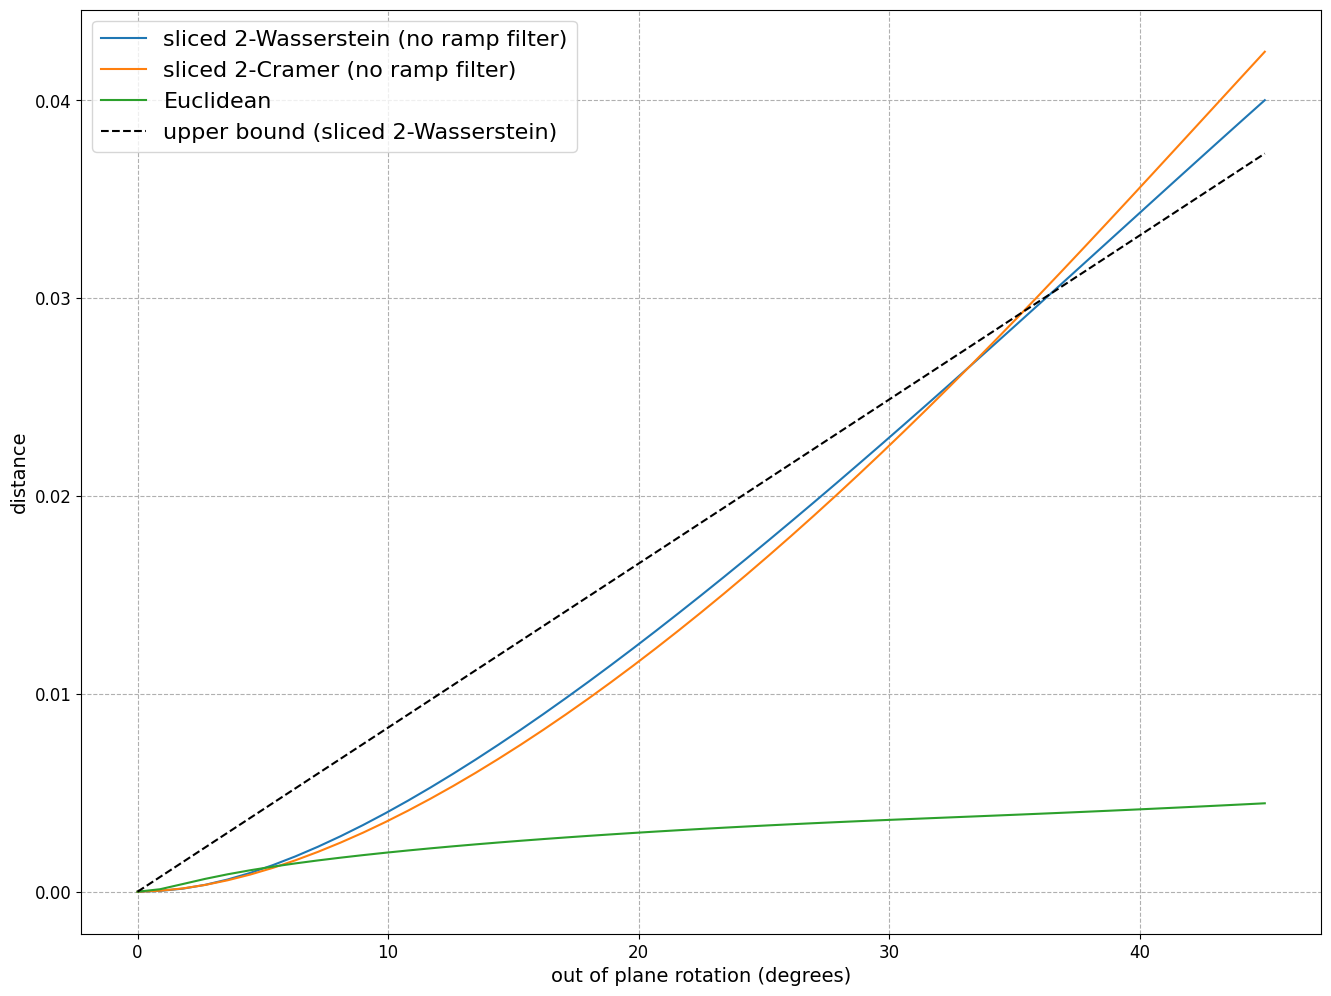

In [24]:
plt.figure(figsize=(16,12))

# plt.plot(t[1:], dists_sw_nrf[1:] / np.amax(dists_sw_nrf[1:]), label='sliced 2-Wasserstein (no ramp filter)')

# plt.plot(t[1:], dists_sw_avg[1:] / np.amax(dists_sw_avg[1:]), label='sliced 2-Wasserstein (averaged)')
# plt.plot(t[1:], dists_sw_max[1:] / np.amax(dists_sw_max[1:]), label='max sliced 2-Wasserstein')

# plt.plot(t[1:], dists_sc_nrf[1:] / np.amax(dists_sc_nrf[1:]), label='sliced 2-Cramer (no ramp filter)')

# # plt.plot(t, dists_emd, label='Wavelet EMD')
# plt.plot(t[1:], dists_bfr[1:] / np.amax(dists_bfr[1:]), label='Euclidean')
# # plt.plot(t, dists_w2, label='2-Wasserstein')


plt.plot(t[:], dists_sw_nrf[:] , label='sliced 2-Wasserstein (no ramp filter)')
# plt.plot(t[:], dists_sw_avg[:] , label='sliced 2-Wasserstein (averaged)')
# plt.plot(t[1:], dists_sw_max[1:] , label='max sliced 2-Wasserstein')
plt.plot(t[:], dists_sc_nrf[:] , label='sliced 2-Cramer (no ramp filter)')
# plt.plot(t, dists_emd, label='Wavelet EMD')
plt.plot(t[:], dists_bfr[:] , label='Euclidean')
# plt.plot(t, dists_w2, label='2-Wasserstein')
plt.plot(t, upper_bound_sw, color='k', linestyle='--', label='upper bound (sliced 2-Wasserstein)')


# plt.ylim(-0.05, 1.05)
plt.xlabel('out of plane rotation (degrees)')
plt.ylabel('distance')
plt.grid(which='major', linestyle='--')
plt.legend()
# plt.xticks(t[1:])
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=16)
plt.show()

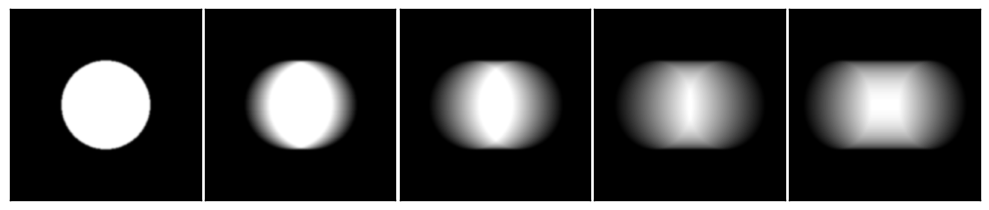

In [25]:
q = N//5

plots.line_tile_plot(imgs[::q+1], 5, size=10, spine_colors=['k' for _ in range(10)])

In [ ]:
# gt = np.arange(N)

# n_nrf = compute_intersection(gt, np.argsort(dists_sw_nrf), N)
# # n_sgn = compute_intersection(gt, np.argsort(dists_sw_sgn), N)
# n_max = compute_intersection(gt, np.argsort(dists_sw_max), N)
# # n_pos = compute_intersection(gt, np.argsort(dists_sw_pos), N)
# # n_neg = compute_intersection(gt, np.argsort(dists_sw_neg), N)
# n_avg = compute_intersection(gt, np.argsort(dists_sw_avg), N)
# n_emd = compute_intersection(gt, np.argsort(dists_emd), N)
# n_bfr = compute_intersection(gt, np.argsort(dists_bfr), N)


# # plt.figure(figsize=(5,3))
# plt.plot(t, n_nrf, label='nrf')
# # plt.plot(t, n_sgn, label='sgn')
# # plt.plot(t, n_max, label='max')
# # plt.plot(t, n_pos, label='pos')
# # plt.plot(t, n_neg, label='neg')
# plt.plot(t, n_avg, label='avg')
# plt.plot(t, n_emd, label='emd')
# plt.plot(t, n_bfr, label='bfr')
# plt.plot(t, gt+1, color='grey', linestyle='--', label='upper bound')
# plt.legend()
# plt.show()

In [ ]:
imgs_t = transforms.Transform(imgs, apply_ramp=True, angles=angles, n_points=n_points).radon_transform()
imgs_cdf_pos, imgs_cdf_neg = transforms.Transform(imgs, apply_ramp=True, angles=angles, n_points=n_points).signed_cdf_transform()
imgs_icdf_pos, imgs_icdf_neg = transforms.Transform(imgs, apply_ramp=True, angles=angles, n_points=n_points).signed_inverse_cdf_transform()

In [ ]:
idx = 0

# plt.imshow(imgs[idx])
# plt.colorbar()
# plt.show()
# plt.imshow(imgs_t[idx])
# plt.colorbar()
# plt.show()
# plt.imshow(imgs_cdf_pos[idx])
# plt.colorbar()
# plt.show()
# plt.imshow(imgs_icdf_pos[idx])
# plt.colorbar()
# plt.show()
# plt.imshow(imgs_cdf_neg[idx])
# plt.colorbar()
# plt.show()
# plt.imshow(imgs_icdf_neg[idx])
# plt.colorbar()
# plt.show()

plots.two_imshow(imgs[idx], imgs_t[idx])
plots.two_imshow(imgs_cdf_pos[idx], imgs_cdf_neg[idx])
plots.two_imshow(imgs_icdf_pos[idx], imgs_icdf_neg[idx])